# HYFN Capstone Project 
## --- Prediction of engagements in advertisement campaign

### Part 1: Data preparation

In this project, I am using the PostgreSQL interface in Python to access the database on cluster. Since I am focusing on the modeling of campaign level, the table I am interested are :  
1. facebook_daily_campaign_stats  
2. fb_ads_campaign_groups
3. fb_ads_accounts

Table 1 and 2 are first joined by column "campaign_id", the combined table are then joined with table 3 by column "account_id". 

In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
import matplotlib.dates as mdates

In [2]:
fb_daily_campaign_stats_df = pd.read_csv('fb_daily_campaign_stats')
fb_campaign_groups_df = pd.read_csv('fb_campaign_groups')
fb_ads_accounts_df = pd.read_csv('fb_ads_accounts')

In [3]:
stats_group_merge = pd.merge(fb_daily_campaign_stats_df,fb_campaign_groups_df[['service_id','objective','account_id']], how = 'left', left_on = 'campaign_id', right_on = 'service_id')

In [4]:
all_merge = pd.merge(stats_group_merge, fb_ads_accounts_df[['id','name','account_id']], how = 'left', left_on = 'account_id', right_on = 'id')

In [5]:
fb_campaign_df = all_merge

** Table summaries**  
The table "fb_daily_campaign_stats" has 46829 rows in total. However, only 20786 ones have valid "account_id" and associated "objective" after joining.   
We will also only look at the campaign records with objective "LINK_CLICKS", since our aim is to model the relationship between "spend" and "website click". Ad campaign with other objectives may have significantly non-proportional relation between these two variables. The final data point is 6865.  

Example of final data table is named "fb_link_df" and sample rows are also given below.

In [6]:
select_cols = ['account_id_y','name','campaign_id','date_start','spend','inline_link_clicks','objective']
fb_df = fb_campaign_df[select_cols]
fb_df.columns = ['account_id','name','campaign_id','date_start','spend','link_clicks','objective']
fb_link_df = fb_df[fb_df.objective == 'LINK_CLICKS']

In [7]:
# Convert account_id & campaign_id to string
temp = ['{:.0f}'.format(x) for x in fb_link_df.campaign_id]
fb_link_df.loc[fb_link_df.index,'campaign_id'] = temp
temp = ['{:.0f}'.format(x) for x in fb_link_df.account_id]
fb_link_df.loc[fb_link_df.index,'account_id'] = temp

/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
fb_link_df = fb_link_df[fb_link_df.spend > 0]
fb_link_df = fb_link_df[fb_link_df.link_clicks > 0]

** Sample table content:**

In [9]:
fb_link_df.head()

,account_id,name,campaign_id,date_start,spend,link_clicks,objective
0,1012201575494245,Target,6047406179103,2016-05-18,60.55,15.0,LINK_CLICKS
50,345009516,All Clients - LIN Digital,6051253714720,2016-09-20,16.67,52.0,LINK_CLICKS
51,345009516,All Clients - LIN Digital,6049742187920,2016-09-20,50.32,22.0,LINK_CLICKS
53,345009516,All Clients - LIN Digital,6047731536920,2016-09-20,14.39,51.0,LINK_CLICKS
54,345009516,All Clients - LIN Digital,6046540842520,2016-09-20,11.93,9.0,LINK_CLICKS


**Table summary:**

In [10]:
num_account = fb_link_df.account_id.value_counts().shape
num_campaign = fb_link_df.campaign_id.value_counts().shape

print 'Total number of account : %i\nTotal number of campaign: %i' %(num_account[0], num_campaign[0])
print 'The time frame is from %s to %s' %(min(fb_link_df.date_start),max(fb_link_df.date_start))

Total number of account : 32
Total number of campaign: 194
The time frame is from 2016-04-18 to 2016-12-20


** Add in vertical information **

In [11]:
account_vertical_df = pd.read_csv('Hyfn_account_vertical_key.csv')

In [12]:
temp = ['{:.0f}'.format(x) for x in account_vertical_df.account_id]
account_vertical_df.loc[account_vertical_df.index,'account_id'] = temp

In [13]:
account_vertical_df.head()

,name,account_id,vertical,vertical2
0,Usher Security,1011716032209460,Internet Company,Workplace & Office
1,Gogobot,1003305413050520,Travel,NaN
2,QuikTrip,1012680412113020,Convenience Store,NaN
3,Ashford University,1017974154916980,Education,Lead Gen
4,Visit California,868189209895483,Travel,NaN


In [14]:
fb_link_df = pd.merge(fb_link_df, account_vertical_df[['account_id','vertical','vertical2']], how = 'left', left_on = 'account_id', right_on = 'account_id')

In [15]:
fb_link_df.sort_values(['account_id','campaign_id','date_start'], inplace = True)

In [16]:
fb_link_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6668 entries, 1256 to 4319
Data columns (total 9 columns):
account_id     6668 non-null object
name           6668 non-null object
campaign_id    6668 non-null object
date_start     6668 non-null object
spend          6668 non-null float64
link_clicks    6668 non-null float64
objective      6668 non-null object
vertical       3132 non-null object
vertical2      1847 non-null object
dtypes: float64(2), object(7)
memory usage: 520.9+ KB


### Part 2: Data modeling 
### 2.1 Ex post model

1.Convert "campaign_id" into category data(dummy variables)

In [17]:
link_ml_df = pd.concat([fb_link_df, pd.get_dummies(fb_link_df.campaign_id,drop_first=True)], axis = 1)

2.Transform "spend" and "inline_link_clicks" into logrithmic scale

In [18]:
link_ml_df.loc[link_ml_df.index,'log_spend'] = np.log(link_ml_df.spend)
link_ml_df.loc[link_ml_df.index,'log_click'] = np.log(link_ml_df.link_clicks)

3.Drop the redundant columns

In [19]:
link_ml_df.head()

,account_id,name,campaign_id,date_start,spend,link_clicks,objective,vertical,vertical2,23842505131670744,...,6064002893844,6064003490044,6064004160044,6064663893217,6064969908417,6064970231017,6066725507025,6067165333617,log_spend,log_click
1256,1003374119710324,Line Tale 2,6042354718738,2016-04-18,266.96,52.0,LINK_CLICKS,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.587099,3.951244
22,1003374119710324,Line Tale 2,6042354718738,2016-04-19,2756.24,607.0,LINK_CLICKS,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.921623,6.408529
60,1003374119710324,Line Tale 2,6042354718738,2016-04-20,2136.41,625.0,LINK_CLICKS,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.666882,6.437752
825,1003374119710324,Line Tale 2,6042354718738,2016-04-21,1904.17,778.0,LINK_CLICKS,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.551801,6.656727
270,1003374119710324,Line Tale 2,6042354718738,2016-04-22,1688.81,780.0,LINK_CLICKS,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.431779,6.659294


In [20]:
link_ml_df.drop(['account_id','campaign_id','date_start','objective','name','spend','link_clicks','vertical','vertical2'], axis = 1, inplace = True)

Data Frame "link_ml_df" ready for machine learning

In [21]:
link_ml_df.reset_index(drop = True, inplace = True)

In [22]:
link_ml_df.head()

,23842505131670744,23842505131810744,23842505131840744,23842505782680160,23842506958430736,23842507000030736,23842507560460492,23842508340700492,23842509683750744,23842509683770744,...,6064002893844,6064003490044,6064004160044,6064663893217,6064969908417,6064970231017,6066725507025,6067165333617,log_spend,log_click
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.587099,3.951244
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.921623,6.408529
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.666882,6.437752
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.551801,6.656727
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.431779,6.659294


In [23]:
link_ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Columns: 195 entries, 23842505131670744 to log_click
dtypes: float64(195)
memory usage: 9.9 MB


### Regression Model 1:

\begin{equation*}
log(Clicks) = m* log(spend)+b_{campaign}+b_{int}
\end{equation*}

In this project, I am going to use the ski-learn(ML package built in Python) for various regression problems.

In [24]:
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import metrics

linreg = linear_model.LinearRegression(fit_intercept=True)  # This is the default
X = link_ml_df.copy()
X.drop('log_click', axis = 1, inplace = True)
y = link_ml_df.log_click
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Spend coefficients**:

In [25]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg.coef_[-1]

The spend coefficients between log(spend) and log(clicks) (m) is 0.91


**In-sample prediction metric**:

In [26]:
print "The in-sample prediction R^2 is %.4f" % linreg.score(X,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg.predict(X))

The in-sample prediction R^2 is 0.9468
The mean squared error in model is 0.1534


**Visualization**

In [27]:
x0 = X.loc[X.index[0]] 
X0 = pd.DataFrame({}, columns = X.columns)
X0 = X0.append([x0]*50,ignore_index=True)
X0['log_spend'] = pd.Series(np.linspace(0, 10, 50))

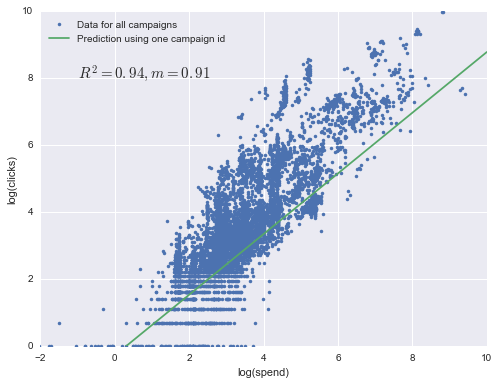

In [69]:
plt.figure(figsize=(8,6))
plt.plot(X.log_spend, y, '.')
plt.plot(X0.log_spend, linreg.predict(X0), '-')
plt.xlabel('log(spend)')
plt.ylabel('log(clicks)')
plt.axis([-2, 10, 0, 10])
plt.legend(['Data for all campaigns','Prediction using one campaign id'],loc='best')
plt.text(-1, 8, r'$R^2 = 0.94, m = 0.91$', fontsize=15)
plt.savefig('Ex-post.png')

**Coefficients of Regression model (variation in campaigns $b_{campaign}$)** 

In [29]:
coeffs = linreg.coef_[:-1]

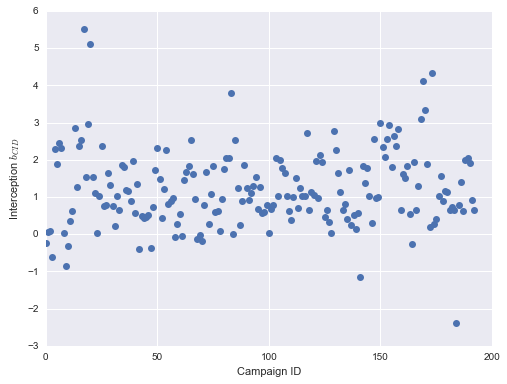

In [30]:
plt.figure(figsize=(8,6))
plt.plot(coeffs,'o')
plt.xlabel('Campaign ID')
plt.ylabel('Interception $b_{CID}$')
#plt.axis([0, 12, -2, 6])

Now, we can compare the effectiveness of various campaign. From the plot, it seems most of the campaign are close and in a clustered way. However, there are some outliers as well. It may be interesting to look at those campaign individually and see what are the reasons for these differences.

In [31]:
coeffs_group1 = X.columns[coeffs > 3]
coeffs_group2 = X.columns[coeffs < 0]

/Applications/anaconda/lib/python2.7/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 194 but corresponding boolean dimension is 193
  result = getitem(key)


In [32]:
coeffs_group1_name = list()
for id in coeffs_group1:
    company_name = fb_link_df[fb_link_df.campaign_id == str(id)].name
    coeffs_group1_name.append(company_name.values[0])
    
coeffs_group1_name

['Olympics',
 'Olympics',
 'Visit California',
 'Micro Strategy',
 'Micro Strategy',
 'Micro Strategy',
 'Micro Strategy']

In [33]:
coeffs_group2_name = list()
for id in coeffs_group2:
    company_name = fb_link_df[fb_link_df.campaign_id == str(id)].name
    coeffs_group2_name.append(company_name.values[0])
    
coeffs_group2_name

['Chime',
 'Intel - HYFN',
 'Chime',
 'Chime',
 'All Clients - LIN Digital',
 'Target',
 'All Clients - LIN Digital',
 'All Clients - LIN Digital',
 'John Muir',
 'John Muir',
 'John Muir',
 'HYFN8 Campaign',
 'TrueCar Main: 106471106226037',
 'Micro Strategy',
 'TrueCar Main: 106471106226037']

Before building the ex ante model, we can also do a cross-validation on our current model to evaluate its ability.

### Cross-validation

split the data set into training data (70%) and testing data (30%).

In [34]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mse_test = metrics.mean_squared_error(y_test.values, y_pred)

[0, 10, 0, 10]

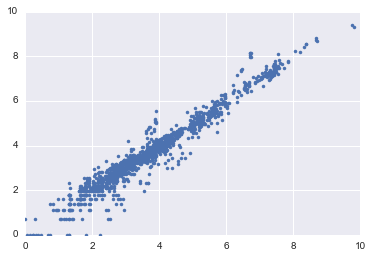

In [35]:
plt.plot(y_pred,y_test.values,'.')
plt.axis([0,10,0,10])

In [36]:
from math import e
factor1 = e**(-np.sqrt(mse_test))
factor2 = e**(np.sqrt(mse_test))
print "The mean squared error in test data set is %.4f" %mse_test
print "In prediction of link clicks, this error corresponds to a factor between %.2f to %.2f" %(factor1,factor2)

The mean squared error in test data set is 0.1439
In prediction of link clicks, this error corresponds to a factor between 0.68 to 1.46


### 2.1 Ex ante model

### Baseline Model :

\begin{equation*}
log(Clicks) = m* log(spend)+b_{int}
\end{equation*}

In [37]:
X_base = link_ml_df.log_spend.reshape(-1,1)
y = link_ml_df.log_click

In [38]:
linreg_base = linear_model.LinearRegression(fit_intercept=True)
linreg_base.fit(X_base,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg_base.coef_[-1]
print "The in-sample prediction R^2 is %.4f" % linreg_base.score(X_base,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg_base.predict(X_base))

The spend coefficients between log(spend) and log(clicks) (m) is 1.05
The in-sample prediction R^2 is 0.6789
The mean squared error in model is 0.9261


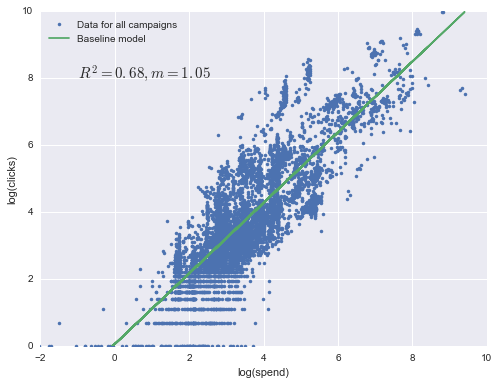

In [73]:
plt.figure(figsize=(8,6))
plt.plot(X_base, y, '.')
plt.plot(X_base, linreg_base.predict(X_base), '-')
plt.xlabel('log(spend)')
plt.ylabel('log(clicks)')
plt.axis([-2, 10, 0, 10])
plt.legend(['Data for all campaigns','Baseline model'],loc='best')
plt.text(-1, 8, r'$R^2 = 0.68, m = 1.05$', fontsize=15)
plt.savefig('Baseline.png')

### Vertical Model :

\begin{equation*}
log(Clicks) = m* log(spend)+b_{int}+b_{vert}
\end{equation*}

In [40]:
fb_link_df.fillna(value = 'Unknown', inplace = True)

In [41]:
fb_link_df.head()

,account_id,name,campaign_id,date_start,spend,link_clicks,objective,vertical,vertical2
1256,1003374119710324,Line Tale 2,6042354718738,2016-04-18,266.96,52.0,LINK_CLICKS,Unknown,Unknown
22,1003374119710324,Line Tale 2,6042354718738,2016-04-19,2756.24,607.0,LINK_CLICKS,Unknown,Unknown
60,1003374119710324,Line Tale 2,6042354718738,2016-04-20,2136.41,625.0,LINK_CLICKS,Unknown,Unknown
825,1003374119710324,Line Tale 2,6042354718738,2016-04-21,1904.17,778.0,LINK_CLICKS,Unknown,Unknown
270,1003374119710324,Line Tale 2,6042354718738,2016-04-22,1688.81,780.0,LINK_CLICKS,Unknown,Unknown


In [42]:
ml_vert_df = fb_link_df[['spend','link_clicks','vertical','vertical2']]

In [43]:
ml_vert_df = pd.concat([ml_vert_df, pd.get_dummies(ml_vert_df.vertical,drop_first=True),pd.get_dummies(ml_vert_df.vertical2,drop_first=True)], axis = 1)

In [44]:
ml_vert_df.loc[ml_vert_df.index,'log_spend'] = np.log(ml_vert_df.spend)
ml_vert_df.loc[ml_vert_df.index,'log_click'] = np.log(ml_vert_df.link_clicks)

In [45]:
[ml_vert_df.vertical.value_counts().index,ml_vert_df.vertical2.value_counts().index]

[Index([u'Unknown', u'Internet Company', u'Travel', u'Health Care', u'Retail',
        u'Pregnancy', u'Entertainment', u'Non-Profit', u'Automotive', u'QSR',
        u'Technology', u'Public Health', u'Advertising'],
       dtype='object'),
 Index([u'Unknown', u'Workplace & Office', u'Lead Gen', u'Apparel', u'CPG',
        u'Health', u'Movie', u'Seniors', u'Loan'],
       dtype='object')]

In [46]:
ml_vert_df.drop(['vertical','vertical2','Unknown','spend','link_clicks'], axis =1, inplace = True)

In [47]:
ml_vert_df.columns

Index([u'Automotive', u'Entertainment', u'Health Care', u'Internet Company',
       u'Non-Profit', u'Pregnancy', u'Public Health', u'QSR', u'Retail',
       u'Technology', u'Travel', u'CPG', u'Health', u'Lead Gen', u'Loan',
       u'Movie', u'Seniors', u'Workplace & Office', u'log_spend',
       u'log_click'],
      dtype='object')

In [48]:
ml_vert_df.head()

,Automotive,Entertainment,Health Care,Internet Company,Non-Profit,Pregnancy,Public Health,QSR,Retail,Technology,Travel,CPG,Health,Lead Gen,Loan,Movie,Seniors,Workplace & Office,log_spend,log_click
1256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.587099,3.951244
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.921623,6.408529
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.666882,6.437752
825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.551801,6.656727
270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.431779,6.659294


In [49]:
linreg_vert = linear_model.LinearRegression(fit_intercept=True)  # This is the default
X_vert = ml_vert_df.copy()
X_vert.drop('log_click', axis = 1, inplace = True)
y = ml_vert_df.log_click
linreg_vert.fit(X_vert, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
print "The spend coefficients between log(spend) and log(clicks) (m) is %.2f" % linreg_vert.coef_[-1]
print "The in-sample prediction R^2 is %.4f" % linreg_vert.score(X_vert,y)
print "The mean squared error in model is %.4f" % metrics.mean_squared_error(y,linreg_vert.predict(X_vert))

The spend coefficients between log(spend) and log(clicks) (m) is 1.09
The in-sample prediction R^2 is 0.7360
The mean squared error in model is 0.7613


### Visualization

In [51]:
fb_link_df.head()

,account_id,name,campaign_id,date_start,spend,link_clicks,objective,vertical,vertical2
1256,1003374119710324,Line Tale 2,6042354718738,2016-04-18,266.96,52.0,LINK_CLICKS,Unknown,Unknown
22,1003374119710324,Line Tale 2,6042354718738,2016-04-19,2756.24,607.0,LINK_CLICKS,Unknown,Unknown
60,1003374119710324,Line Tale 2,6042354718738,2016-04-20,2136.41,625.0,LINK_CLICKS,Unknown,Unknown
825,1003374119710324,Line Tale 2,6042354718738,2016-04-21,1904.17,778.0,LINK_CLICKS,Unknown,Unknown
270,1003374119710324,Line Tale 2,6042354718738,2016-04-22,1688.81,780.0,LINK_CLICKS,Unknown,Unknown


In [52]:
fb_link_df.vertical.value_counts()

Unknown             3536
Internet Company    1201
Travel              1043
Health Care          449
Retail               249
Pregnancy             54
Entertainment         52
Non-Profit            25
Automotive            23
QSR                   17
Technology            10
Public Health          6
Advertising            3
Name: vertical, dtype: int64

In [53]:
fb_Internet_df = fb_link_df[fb_link_df.vertical == "Internet Company"]
fb_Travel_df = fb_link_df[fb_link_df.vertical == "Travel"]
fb_Health_df = fb_link_df[fb_link_df.vertical == "Health Care"]
fb_Retail_df = fb_link_df[fb_link_df.vertical == "Retail"]
fb_Entertainment_df = fb_link_df[fb_link_df.vertical == "Entertainment"]
fb_Auto_df = fb_link_df[fb_link_df.vertical == "Automotive"]
fb_QSR_df = fb_link_df[fb_link_df.vertical == "QSR"]
fb_Tech_df = fb_link_df[fb_link_df.vertical == "Technology"]

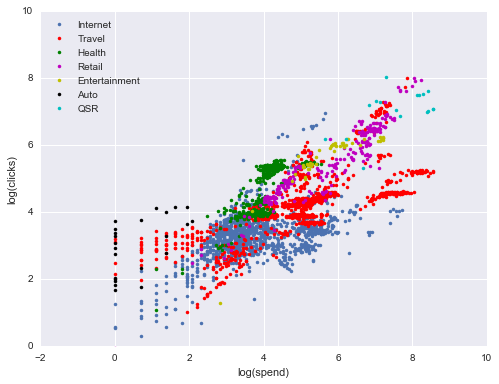

In [54]:
plt.figure(figsize=(8,6))
plt.plot(np.log(fb_Internet_df.link_clicks),np.log(fb_Internet_df.spend), '.')
plt.plot(np.log(fb_Travel_df.link_clicks),np.log(fb_Travel_df.spend), 'r.')
plt.plot(np.log(fb_Health_df.link_clicks),np.log(fb_Health_df.spend), 'g.')
plt.plot(np.log(fb_Retail_df.link_clicks),np.log(fb_Retail_df.spend), 'm.')
plt.plot(np.log(fb_Entertainment_df.link_clicks),np.log(fb_Entertainment_df.spend), 'y.')
plt.plot(np.log(fb_Auto_df.link_clicks),np.log(fb_Auto_df.spend), 'k.')
plt.plot(np.log(fb_QSR_df.link_clicks),np.log(fb_QSR_df.spend), 'c.')
#plt.plot(np.log(fb_Tech_df.link_clicks),np.log(fb_Tech_df.spend), 'r.')
#plt.plot(X0.log_spend, linreg.predict(X0), '-')

plt.xlabel('log(spend)')
plt.ylabel('log(clicks)')
plt.axis([-2, 10, 0, 10])
plt.legend(['Internet','Travel','Health','Retail','Entertainment','Auto','QSR'],loc='best')

In [55]:
fb_link_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6668 entries, 1256 to 4319
Data columns (total 9 columns):
account_id     6668 non-null object
name           6668 non-null object
campaign_id    6668 non-null object
date_start     6668 non-null object
spend          6668 non-null float64
link_clicks    6668 non-null float64
objective      6668 non-null object
vertical       6668 non-null object
vertical2      6668 non-null object
dtypes: float64(2), object(7)
memory usage: 520.9+ KB


### Add in time features

In [56]:
temp = [datetime.strptime(x,"%Y-%m-%d") for x in fb_link_df.date_start]
fb_link_df.loc[fb_link_df.index,'date_start'] = temp

In [57]:
month =[ x.date().month for x in fb_link_df.date_start]
fb_link_df.loc[fb_link_df.index,'month'] = month

In [58]:
Month_dict = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9:'Sep', 10:'Oct', 11:'Nov',12: 'Dec'}

In [59]:
fb_link_df['month'] = fb_link_df['month'].map(Month_dict)

In [60]:
fb_link_df.month.value_counts()

Oct    2863
Nov    1747
Sep    1231
Dec     771
Jun      26
Jul      15
Apr       8
May       7
Name: month, dtype: int64

In [61]:
fb_Apr_May_df = fb_link_df[(fb_link_df.month == "Apr") | (fb_link_df.month == "May") ]
fb_Jun_Jul_df = fb_link_df[(fb_link_df.month == "Jun") | (fb_link_df.month == "Jul") ]
fb_Sep_df = fb_link_df[(fb_link_df.month == "Sep")]
fb_Oct_df = fb_link_df[(fb_link_df.month == "Oct")]
fb_Nov_df = fb_link_df[(fb_link_df.month == "Nov")]
fb_Dec_df = fb_link_df[(fb_link_df.month == "Dec")]

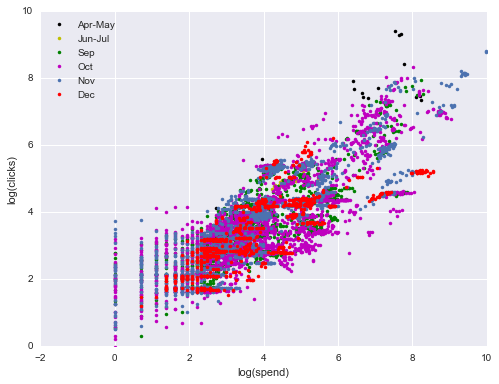

In [62]:
plt.figure(figsize=(8,6))
plt.plot(np.log(fb_Apr_May_df.link_clicks),np.log(fb_Apr_May_df.spend), 'k.')
plt.plot(np.log(fb_Jun_Jul_df.link_clicks),np.log(fb_Jun_Jul_df.spend), 'y.')
plt.plot(np.log(fb_Sep_df.link_clicks),np.log(fb_Sep_df.spend), 'g.')
plt.plot(np.log(fb_Oct_df.link_clicks),np.log(fb_Oct_df.spend), 'm.')
plt.plot(np.log(fb_Nov_df.link_clicks),np.log(fb_Nov_df.spend), '.')
plt.plot(np.log(fb_Dec_df.link_clicks),np.log(fb_Dec_df.spend), 'r.')

plt.xlabel('log(spend)')
plt.ylabel('log(clicks)')
plt.axis([-2, 10, 0, 10])
plt.legend(['Apr-May','Jun-Jul','Sep','Oct','Nov','Dec'],loc='best')